<a href="https://colab.research.google.com/github/AsmaaQ25/GenAI-CMP637-2025/blob/main/Notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CMP637-GenAI Assignment-phase1 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### November 2025
 # Report and plot history here https://wandb.ai/asmaaqandeel2511-cairo-university/GenAI-Assignment-phase1/reports/MNIST-GenAI--VmlldzoxNTIzNTgxOQ?accessToken=3046w987dk9m7ddxr1ho4whrxp8bykyvh1kqu122a4qyozhxsc174qd21pcxnjde 

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Define utility functions

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

 ## Load and visualize the dataset
 I added image Flattening

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.58MB/s]


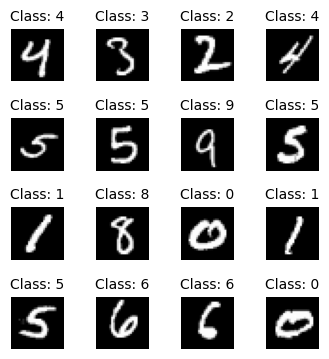

In [4]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

## Select a device

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContinuousConditionalMADE(nn.Module):
    def __init__(
        self,
        input_size=784,
        cond_size=10,
        hidden_sizes=[512, 512],
        natural_ordering=True,
    ):
        super().__init__()

        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_sizes = hidden_sizes

        
        if natural_ordering:
            degrees_input = torch.arange(1, input_size + 1)
        else:
            degrees_input = torch.randperm(input_size) + 1

        degrees_hidden = []
        for h in hidden_sizes:
            degrees_hidden.append(torch.randint(1, input_size, (h,)))

        degrees_output = torch.arange(1, input_size + 1)

        # Register as buffers so PyTorch moves them automatically
        self.register_buffer("degrees_input", degrees_input)
        self.degrees_hidden = nn.ParameterList(
            [nn.Parameter(d, requires_grad=False) for d in degrees_hidden]
        )
        self.register_buffer("degrees_output", degrees_output)

        
        layers = []
        layer_in = input_size + cond_size

        for h in hidden_sizes:
            layers.append(nn.Linear(layer_in, h))
            layer_in = h

        layers.append(nn.Linear(layer_in, 2 * input_size))
        self.layers = nn.ModuleList(layers)

        masks = self.build_masks()
        self.masks = nn.ParameterList(
            [nn.Parameter(m, requires_grad=False) for m in masks]
        )

    def build_masks(self):
        masks = []
        degrees_prev = torch.cat([torch.zeros(self.cond_size), self.degrees_input])

        # hidden layers
        for d_h in self.degrees_hidden:
            mask = (degrees_prev[:, None] <= d_h[None, :]).float()
            masks.append(mask)
            degrees_prev = d_h

        # output mask
        mask_out = (degrees_prev[:, None] < self.degrees_output.repeat(2)[None, :]).float()
        masks.append(mask_out)

        return masks

    def forward(self, x, y_cond):
        device = next(self.parameters()).device  # get model device
        x = x.to(device)
        y_cond = y_cond.to(device)
        
        h = torch.cat([x, y_cond], dim=-1)
    
        for layer, mask in zip(self.layers, self.masks):
            W = layer.weight * mask.T
            h = F.linear(h, W, layer.bias)
            if layer is not self.layers[-1]:
                h = F.relu(h)
    
        return h
        
    @torch.no_grad()
    def sample(self, y_cond, device):
        """
        y_cond: [B, cond_size]
        """
        batch = y_cond.size(0)
        x = torch.zeros(batch, self.input_size, device=device)

        for i in range(self.input_size):
            out = self.forward(x, y_cond)
            mu, logvar = out[:, :self.input_size], out[:, self.input_size:]
            sigma = torch.exp(0.5 * logvar)

            x[:, i] = mu[:, i] + sigma[:, i] * torch.randn(batch, device=device)

        return x


# Instantiate model and optim
# Trainig

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Loss function for continuous generation (mnist is continuous floats)
def gaussian_nll(mu, logvar, x):
    """
    mu:     [B, D]
    logvar: [B, D]
    x:      [B, D]
    """
    inv_var = torch.exp(-logvar)
    nll = 0.5 * (logvar + (x - mu)**2 * inv_var)
    return nll.sum(dim=1).mean()   # average over batch

#training function for the model 

def train_continuous_made(model, dataloader, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):

            # prepare data
            x = x.to(device)                        # [B, 784]
            y_cond = nn.functional.one_hot(y, 10).float().to(device)

            # forward feed
            out = model(x, y_cond)
            mu = out[:, :model.input_size]
            logvar = out[:, model.input_size:]

            # loss
            loss = gaussian_nll(mu, logvar, x)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_losses.append(epoch_loss)
        wandb.log({"epoch": epoch , "NLL": epoch_loss})
        print(f"Epoch {epoch}: NLL = {epoch_loss:.4f}")

    print("Training complete.")
    return epoch_losses


In [69]:
# TODO: Define the hyperparameters here.
input_dim = 28*28 # for a flat image
hidden_dim = [12455,12455] # two layers each is 8000
# actv = "relu"
# grad_clip = 5.0
# n_mixtures = 10
model = ContinuousConditionalMADE(
    input_size= input_dim,
    cond_size=10,
    hidden_sizes= hidden_dim,
)

In [70]:
# usage
# training parameters
epochs = 7
batch_size = 64
lr = 1e-4

# prepare data
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# prepare logger Weights and biases (Wandb)
################ 

wandb.login(key="9bf31a65f3249f4d45183b47993a4fdc3328db1f")
wandb_logger = wandb.init(project="GenAI-Assignment-phase1", name="made_continuous_12k-e-4",
                         config = {
                        "learning_rate": lr,
                        "batch_size": batch_size,
                        "optimizer": "adam",
                        "epochs": epochs,
                        "model_architecture": "MADE-Continuous",
                         "hidden_layers": hidden_dim }) 

loss_history = train_continuous_made(model, train_loader, epochs=epochs, lr=lr, device='cuda')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


NLL,█▄▃▂▁
epoch,▁▃▅▆█
NLL,-2611.93742
epoch,5


Epoch 1/7: 100%|██████████| 938/938 [01:58<00:00,  7.94it/s]


Epoch 1: NLL = -1283.0648


Epoch 2/7: 100%|██████████| 938/938 [01:56<00:00,  8.03it/s]


Epoch 2: NLL = -1759.3722


Epoch 3/7: 100%|██████████| 938/938 [01:56<00:00,  8.05it/s]


Epoch 3: NLL = -2023.8531


Epoch 4/7: 100%|██████████| 938/938 [01:55<00:00,  8.09it/s]


Epoch 4: NLL = -2220.9312


Epoch 5/7: 100%|██████████| 938/938 [01:55<00:00,  8.09it/s]


Epoch 5: NLL = -2359.4401


Epoch 6/7: 100%|██████████| 938/938 [01:56<00:00,  8.06it/s]


Epoch 6: NLL = -2488.3602


Epoch 7/7: 100%|██████████| 938/938 [01:56<00:00,  8.06it/s]

Epoch 7: NLL = -2630.0090
Training complete.


# Plot the loss function
for more detailed report visit my wandb report here to show all the loss and training experiments.

Well, not all, but the last working ones :-D 

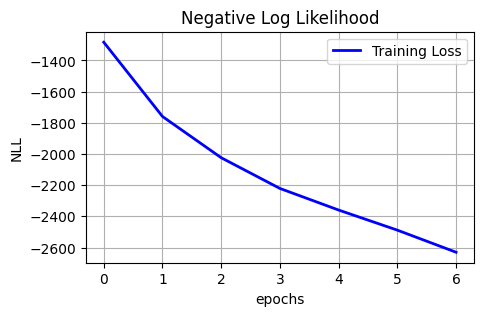

In [71]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

plt.title('Negative Log Likelihood')
plt.xlabel('epochs')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [72]:
# ## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "made_temp.pth")

# loaded_model = ContinuousConditionalMADE(
#     input_size=input_dim,
#     cond_size=10,
#     hidden_sizes=hidden_dim,
# )
# # loaded_model = ConditionalMADE(input_size=input_dim,
# #                         cond_size=10,
# #                         hidden_sizes=hidden_dim,
# #                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_temp.pth"))

## Generate some images and display them

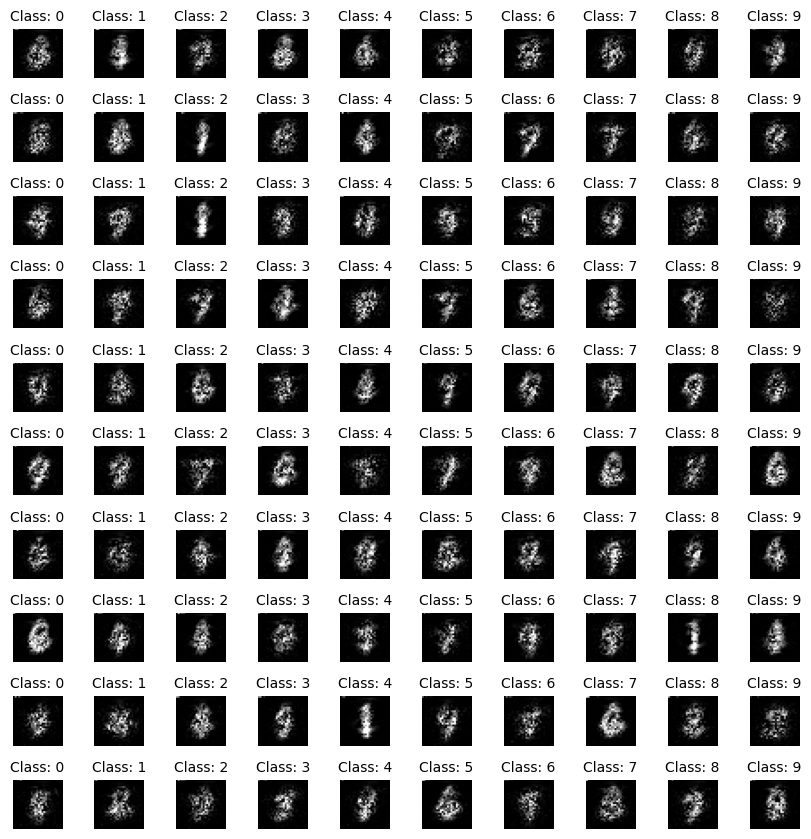

In [73]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval() # put model in evaluation mode
    new_x = model.sample(y_cond, device = device)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

In [74]:
# log images in wandb
x = x.view(x.shape[0], 1, 28, 28) # un-flatten the images
if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
    
batch_size = x.shape[0]

# Draw a grid or images
wandb_image_list = []
sample_table = wandb.Table(columns=["images", "labels"])
for i in range(batch_size):
    caption_text = f"Label: {y[i].item()}"
    wandb_image = wandb.Image(x[i], caption=caption_text)
    wandb_image_list.append(wandb_image)
    
# 4. Log the entire list in a single wandb.log() call
wandb.log({"Generated Samples Grid": wandb_image_list})
# wandb_logger.finish()

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).